In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch
import matplotlib.patches
import matplotlib.transforms as transforms

import matplotlib.gridspec as gridspec

import matplotlib as mpl
import matplotlib.font_manager
mpl.rcParams['font.family'] = 'Arial'

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import seaborn as sns
from itertools import groupby

plt.style.use('ggplot')
pd.set_option('chained_assignment',None)

sys.path.append(os.path.join( '..'))
from miriam_py.utils import load_config
data_path = load_config()['paths']['data']

In [2]:
%%time
global_countries = gpd.read_file(os.path.join(data_path,'input_data','global_countries.shp'))
global_regions = gpd.read_file(os.path.join(data_path,'input_data','global_regions_v2.shp'))

Wall time: 8.83 s


In [3]:
incomegroups = pd.read_csv(os.path.join(data_path,'input_data','incomegroups_2018.csv'),index_col=[0])
tot_road = pd.read_csv(os.path.join(data_path,'summarized','total_exposure_100prot.csv'))
tot_road = tot_road.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_road = tot_road.loc[tot_road.GroupCode.isin(['LIC','HIC','UMC','LMC'])]
#tot_road = tot_road.loc[tot_road.road_type.isin(['primary','secondary','tertiary'])]

all_road_stats = pd.read_feather(os.path.join(data_path,'summarized','all_road_stats.ft'))
all_road_stats = pd.DataFrame(all_road_stats.groupby('region').sum().max(axis=1),columns=['all_risk_road'])
tot_road_inb = tot_road.drop([x for x in tot_road.columns if ('risk_1' in x) | ('risk_2' in x)],axis='columns')
region_risk_road = pd.DataFrame(tot_road_inb.groupby('region').sum().sum(axis=1),columns=['tot_risk_road'])
region_risk_road = region_risk_road.merge(all_road_stats,left_index=True,right_index=True)
region_risk_road['rel_risk'] = (region_risk_road.tot_risk_road/region_risk_road.all_risk_road)*100
global_road = global_regions.merge(region_risk_road,left_on='GID_2',right_index=True,how='outer').fillna(0)

In [4]:
tot_rail = pd.read_csv(os.path.join(data_path,'summarized','total_exposure_100prot_rail.csv'))
tot_rail = tot_rail.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_rail = tot_rail.loc[tot_rail.GroupCode.isin(['LIC','HIC','UMC','LMC'])]
# list of railway segments to remove
rail_to_remove =['disused','abandoned','dismantled','preserved', 'proposed','razed', 
                 'planned','no','historical','na','not_built','abandonned', 'uncompleted', 'demolished',
                 'abandoned_tram','construction;rail', 'rail;construction','waste_disposal','collapsed']

tot_rail = tot_rail.loc[~(tot_rail.infra_type.isin(rail_to_remove))]

all_rail_stats = pd.read_feather(os.path.join(data_path,'summarized','all_railway_stats.ft'))
all_rail_stats = pd.DataFrame(all_rail_stats.groupby('region').sum().max(axis=1),columns=['all_risk_rail'])
tot_rail_inb = tot_rail.drop([x for x in tot_rail.columns if ('risk_1' in x) | ('risk_2' in x)],axis='columns')
region_risk_rail = pd.DataFrame(tot_rail_inb.groupby('region').sum().sum(axis=1),columns=['tot_risk_rail'])
region_risk_rail = region_risk_rail.merge(all_rail_stats,left_index=True,right_index=True)
region_risk_rail['rel_risk'] = (region_risk_rail.tot_risk_rail/region_risk_rail.all_risk_rail)*100
global_rail = global_regions.merge(region_risk_rail,left_on='GID_2',right_index=True,how='outer').fillna(0)

In [5]:
%%time
global_infra = global_road.copy()
global_infra['tot_risk'] = global_road['tot_risk_road'] + global_rail['tot_risk_rail']
global_infra['all_risk'] = global_road['all_risk_road'] + global_rail['all_risk_rail']
global_infra['rel_risk'] = (global_infra.tot_risk/global_infra.all_risk)*100
global_infra = global_infra.loc[~(global_infra.geometry == 0)]
global_infra['geometry'] = global_infra.buffer(0.075)
summed_all = tot_road.groupby('GroupCode').sum() + tot_rail.groupby('GroupCode').sum()

Wall time: 2min 16s


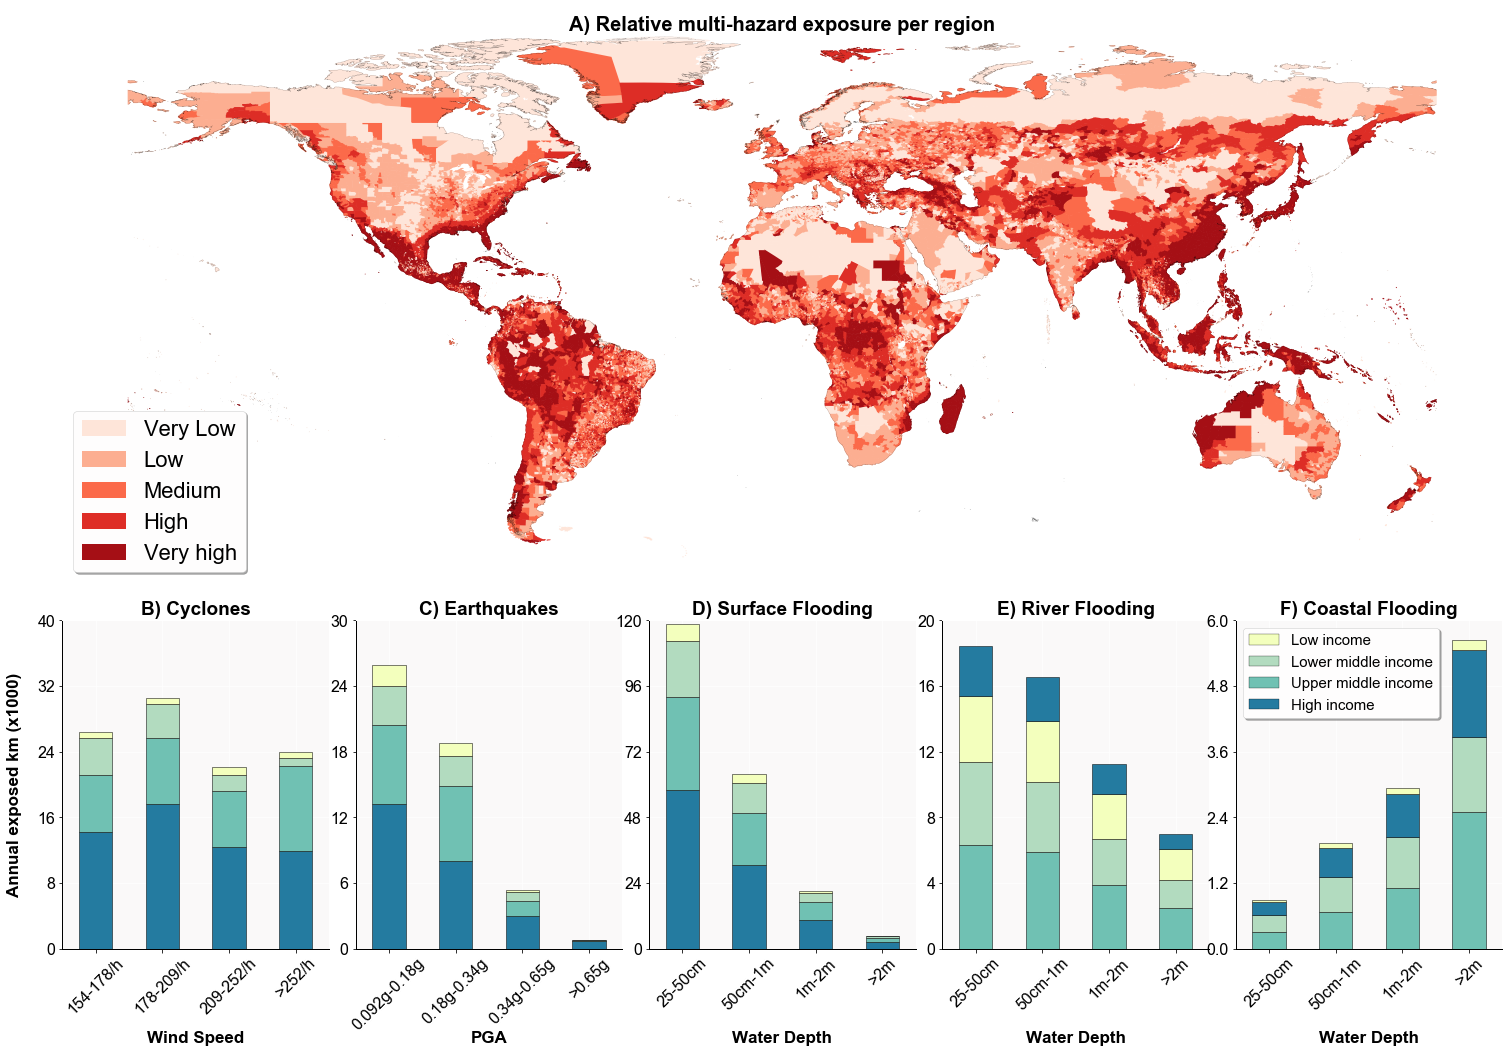

In [17]:
fig = plt.figure(figsize=(20,18))

gs = gridspec.GridSpec(3, 5)
gs.update(left=0.0, right=1, wspace=0.1,hspace=-0.01)

ax_gdp = plt.subplot(gs[:-1, :])
labels = [0,1,2,3,4]
label_names = ['Very Low','Low','Medium','High','Very high']
color_scheme_map =  ['#fee5d9','#fcae91','#fb6a4a','#de2d26','#a50f15'] # ['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
letters = ['A','B','C','D','E','F']


color_scheme = ['#F3FFBD','#B2DBBF','#70C1B3','#247BA0'] #['#bae4bc','#7bccc4','#43a2ca','#0868ac']
income_dict = ['LIC', 'LMC', 'UMC', 'HIC']
color_lookup = dict(zip(income_dict,color_scheme))

hazards = ['Cyc','EQ','PU','FU','CF']
hazards_full = ['Cyclones','Earthquakes','Surface Flooding','River Flooding','Coastal Flooding']

cmap = LinearSegmentedColormap.from_list(name='continents',
                                     colors=color_scheme_map)  

coastlines = gpd.read_file(os.path.join(data_path,'input_data','ne_10m_coastline.shp'))
coastlines = coastlines.cx[-180:180, -50:90]
coastlines.plot(ax=ax_gdp,facecolor = 'none',edgecolor='black',linewidth=0.1)

bins = [-1,global_infra.rel_risk.quantile(0.2),global_infra.rel_risk.quantile(0.4),global_infra.rel_risk.quantile(0.6),
         global_infra.rel_risk.quantile(0.8),global_infra.rel_risk.quantile(1)]
global_infra['risk_gdp_bin'] = pd.cut(global_infra['rel_risk'], bins=bins, labels=labels).fillna(0)
global_infra.plot(column='risk_gdp_bin',ax=ax_gdp,cmap=cmap,linewidth=0)


legend_elements = [Patch(facecolor=color_scheme_map[0],label=label_names[0]),
                  Patch(facecolor=color_scheme_map[1],label=label_names[1]),
                  Patch(facecolor=color_scheme_map[2],label=label_names[2]),
                  Patch(facecolor=color_scheme_map[3],label=label_names[3]),
                  Patch(facecolor=color_scheme_map[4],label=label_names[4])]        

legend = ax_gdp.legend(handles=legend_elements, shadow=True, 
                   fancybox=True,facecolor='#fefdfd',prop={'size':22},loc='lower left')

ax_gdp.text(0.5, 0.99, '{}) Relative multi-hazard exposure per region'.format(letters[0]), transform=ax_gdp.transAxes,
            fontweight="bold",color='black', fontsize=20,    verticalalignment='top',horizontalalignment='center', 
            bbox= dict(boxstyle='round', facecolor='white', alpha=0.5,linewidth=0))

ax_gdp.set_xticks([])
ax_gdp.set_yticks([])

ax_gdp.patch.set_facecolor('white')

for iter_ in range(5):
    ax_sub = plt.subplot(gs[-1, iter_])
    
    hazard = hazards[iter_]
    sub_summed = summed_all[[x for x in summed_all.columns if (hazard in x)]]
    
    if hazard == 'EQ':
        sub_summed.columns = ['0.092g-0.18g','0.18g-0.34g','0.34g-0.65g','>0.65g']
        sub_summed['color'] = [color_lookup[x] for x in list(sub_summed.index)]
        sub_summed = sub_summed.sort_values(by='0.092g-0.18g',ascending=False)
        sorted_colors = list(sub_summed['color'])
        sub_summed = sub_summed.drop('color',axis=1)
    elif  hazard == 'Cyc':
        sub_summed.columns = ['154-178/h','178-209/h','209-252/h','>252/h']
        sub_summed['color'] = [color_lookup[x] for x in list(sub_summed.index)]
        sub_summed = sub_summed.sort_values(by='154-178/h',ascending=False)
        sorted_colors = list(sub_summed['color'])
        sub_summed = sub_summed.drop('color',axis=1)
    elif  (hazard == 'FU') | (hazard == 'PU') | (hazard == 'CF'):
        sub_summed.columns = ['25-50cm','50cm-1m','1m-2m','>2m']
        sub_summed['color'] = [color_lookup[x] for x in list(sub_summed.index)]
        sub_summed = sub_summed.sort_values(by='25-50cm',ascending=False)
        sorted_colors = list(sub_summed['color'])
        sub_summed = sub_summed.drop('color',axis=1)

    sub_summed = sub_summed/1000
    sub_summed.index.name = None
    cmap = LinearSegmentedColormap.from_list(name='continents',
                                         colors=sorted_colors)    
    if iter_ == 4:
        sub_summed.T.plot(kind='bar',stacked=True,ax=ax_sub,cmap=cmap,edgecolor='black',linewidth=0.5)
        legend_elements = [Patch(facecolor=color_scheme[0],edgecolor='black',linewidth=0.3,label='Low income'),
                          Patch(facecolor=color_scheme[1],edgecolor='black',linewidth=0.3,label='Lower middle income'),
                          Patch(facecolor=color_scheme[2],edgecolor='black',linewidth=0.3,label='Upper middle income'),
                          Patch(facecolor=color_scheme[3],edgecolor='black',linewidth=0.3,label='High income')]        

        legend = ax_sub.legend(handles=legend_elements, shadow=True, 
                           fancybox=True,facecolor='#fefdfd',prop={'size':15})
          
    else:
        sub_summed.T.plot(kind='bar',stacked=True,ax=ax_sub,cmap=cmap,legend=False,linewidth=0.5,edgecolor='black')
        
    if iter_ < 5:
        ax_sub.set_title('{}) {}'.format(letters[iter_+1],hazards_full[iter_]),fontweight='bold',fontsize=19)
        ax_sub.yaxis.set_major_formatter(ScalarFormatter())

    if iter_ == 0:
        ax_sub.set_ylabel('Annual exposed km (x1000)',fontweight='bold',color='black',fontsize=17)
        
    for tick in ax_sub.get_xticklabels():
        tick.set_rotation(45)

    ax_sub.tick_params(axis = 'both',labelsize=16,labelcolor='black',color='black')

    ax_sub.get_xaxis().set_label_coords(0.5,-0.25)
    ax_sub.get_yaxis().set_label_coords(-.15,.5)
    
    yaxis_allticks = [np.arange(0,40.1,8.),np.arange(0,30.1,6),np.arange(0,120.1,24),np.arange(0,20.1,4),np.arange(0,6.1,1.2)]
    
    ax_sub.yaxis.set_ticks(yaxis_allticks[iter_])
    ax_sub.set_ylim(top=yaxis_allticks[iter_][-1])
    
    ax_sub.set_facecolor('#FAF9F9')
    ax_sub.spines['left'].set_color('black')
    ax_sub.spines['bottom'].set_color('black')
    
    if hazard == 'EQ':
        ax_sub.set_xlabel(xlabel='PGA',fontweight="bold",color='black',fontsize=17)
    elif hazard == 'Cyc':
        ax_sub.set_xlabel(xlabel='Wind Speed',fontweight="bold",color='black',fontsize=17)
    else:
        ax_sub.set_xlabel(xlabel='Water Depth',fontweight="bold",color='black',fontsize=17)
        
plt.savefig(os.path.join(data_path,'Figures','Fig1_exposure.png'), bbox_inches='tight')

In [7]:
%%time
tot_dom_hz = pd.DataFrame(tot_road_inb.groupby('region').sum()) #[['risk_4_Cyc','risk_4_EQ','risk_4_PU','risk_4_FU','risk_4_CF']]
tot_dom_hz = tot_dom_hz.loc[~(tot_dom_hz==0).all(axis=1)]
tot_dom_hz = pd.DataFrame(tot_dom_hz.idxmax(axis=1),columns=['dom_hz'])
tot_dom_hz['dom_hz'] = tot_dom_hz['dom_hz'].apply(lambda x: x.split('_')[2])
global_dom_hz = global_infra.merge(tot_dom_hz,
                                     left_on='GID_2',right_index=True,how='outer')
global_dom_hz['dom_hz'] = global_dom_hz.dom_hz.fillna('NA')
global_dom_hz['dom_hz'].loc[global_dom_hz['all_risk_road'] < 10] = 'NA'
global_dom_hz = global_dom_hz.loc[~(global_dom_hz.geometry == 0)]

Wall time: 965 ms


In [8]:
intdict = dict(zip(['NA','EQ','Cyc','PU','FU','CF'],[0,1,2,3,4,5]))
global_dom_hz['int_dom_hz'] = global_dom_hz.dom_hz.apply(lambda x : intdict[x])
global_dom_hz['int_dom_hz'].loc[(global_dom_hz.int_dom_hz == 0) & (global_dom_hz.GID_0.isin(['SDN','AUS','SAU','CHN','CAN','BRA','PER']))] = 3

In [9]:
#ctry_exp['rel_risk'] = ctry_exp['tot_risk'].div(ctry_exp['all_risk'])
ctry_exp = tot_road.groupby('country').sum()
ctry_exp['EQ'] = (ctry_exp['risk_3_EQ']+ctry_exp['risk_4_EQ']).div(tot_road.groupby('country').sum().sum(axis=1))
ctry_exp['Cyc'] = (ctry_exp['risk_3_Cyc']+ctry_exp['risk_4_Cyc']).div(tot_road.groupby('country').sum().sum(axis=1))
ctry_exp['PU'] = (ctry_exp['risk_3_PU']+ctry_exp['risk_4_PU']).div(tot_road.groupby('country').sum().sum(axis=1))
ctry_exp['FU'] = (ctry_exp['risk_3_FU']+ctry_exp['risk_4_FU']).div(tot_road.groupby('country').sum().sum(axis=1))
ctry_exp['CF'] = (ctry_exp['risk_3_CF']+ctry_exp['risk_4_CF']).div(tot_road.groupby('country').sum().sum(axis=1))

In [10]:
global_dom_hz['areadeg'] = global_dom_hz.area

In [11]:
df = pd.DataFrame(global_dom_hz.groupby('dom_hz')['areadeg'].sum())

In [12]:
#df = pd.DataFrame(global_dom_hz['dom_hz'].value_counts())
df = pd.DataFrame(global_dom_hz.groupby('dom_hz')['areadeg'].sum())

df.columns=['val1']
df = df.reindex(['NA', 'EQ', 'Cyc','PU','FU','CF'])
df = df[1:]
df['cum_sum'] = df.val1.cumsum()
df['cum_perc'] = df.cum_sum/df.val1.sum()
df['theta'] = df.cum_perc*360
df['perc'] = df.val1/df.val1.sum()*100
thetas = list(df['theta'])

In [13]:
df['perc']
8+8+39+34+11

100

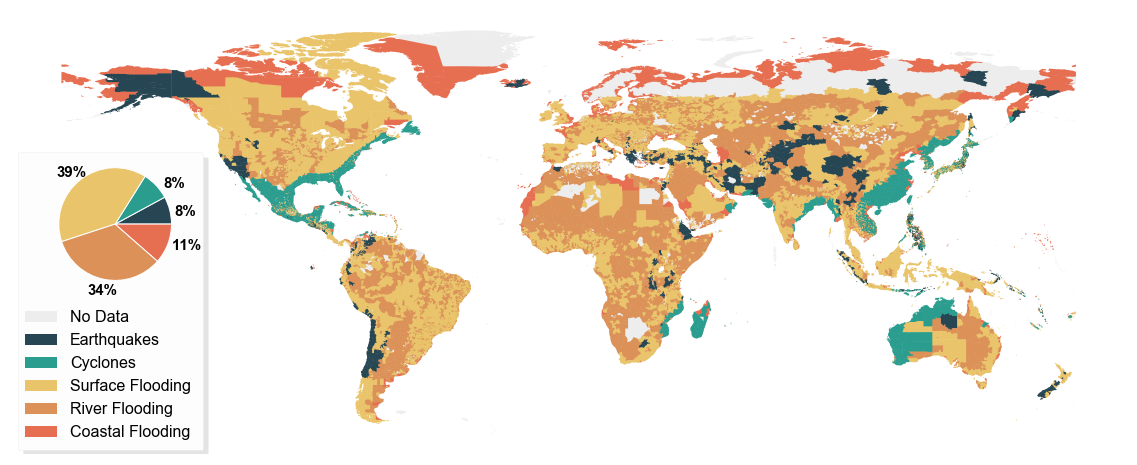

In [14]:
fig, ax = plt.subplots(1, 1,figsize=(20,12))
color_scheme_map = ['#ededed','#264653','#2A9D8F','#E9C46A','#DB9157','#E76F51'] 
hazards_full = ['No Data','Earthquakes','Cyclones','Surface Flooding','River Flooding','Coastal Flooding']

cmap = LinearSegmentedColormap.from_list(name='continents',
                                     colors=color_scheme_map)  

coastlines = gpd.read_file(os.path.join(data_path,'input_data','ne_10m_coastline.shp'))
coastlines = coastlines.cx[-180:180, -50:90]
coastlines.plot(ax=ax_gdp,facecolor = 'none',edgecolor='black',linewidth=0.1)

global_dom_hz.plot(column='int_dom_hz',ax=ax,linewidth=0,cmap=cmap)

legend_elements = [Patch(facecolor=color_scheme_map[0],label=hazards_full[0]),
                  Patch(facecolor=color_scheme_map[1],label=hazards_full[1]),
                  Patch(facecolor=color_scheme_map[2],label=hazards_full[2]),
                  Patch(facecolor=color_scheme_map[3],label=hazards_full[3]),
                   Patch(facecolor=color_scheme_map[4],label=hazards_full[4]),
                  Patch(facecolor=color_scheme_map[5],label=hazards_full[5])]        

legend = ax.legend(handles=legend_elements,edgecolor='#fefdfd',facecolor='#fefdfd',prop={'size':16},loc='lower left') #, shadow=True, fancybox=True,

ax.set_xticks([])
ax.set_yticks([])

wed1 = matplotlib.patches.Wedge((-161, 15), 20, 0, thetas[0],facecolor=color_scheme_map[1],linewidth=1,edgecolor='white')
wed2 = matplotlib.patches.Wedge((-161, 15), 20, thetas[0], thetas[1],facecolor=color_scheme_map[2],linewidth=1,edgecolor='white')
wed3 = matplotlib.patches.Wedge((-161, 15), 20, thetas[1], thetas[2],facecolor=color_scheme_map[3],linewidth=1,edgecolor='white')
wed4 = matplotlib.patches.Wedge((-161, 15), 20, thetas[2], thetas[3],facecolor=color_scheme_map[4],linewidth=1,edgecolor='white')
wed5 = matplotlib.patches.Wedge((-161, 15), 20, thetas[3], thetas[4],facecolor=color_scheme_map[5],linewidth=1,edgecolor='white')

# set translation 
dx, dy = 5/72., -5/72.
offset = transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
shadow_transform = ax.transData + offset

# plot patch shadow
rec1 =  matplotlib.patches.FancyBboxPatch((-195,-65), 65, 105, transform=shadow_transform, 
                         edgecolor = None, boxstyle='round', facecolor = "#e4e4e4")
rec2 = matplotlib.patches.FancyBboxPatch((-195,-65), 65, 105, boxstyle='round',facecolor='#fefdfd')

ax.add_patch(rec1)
ax.add_patch(rec2)

ax.add_patch(wed1)
ax.add_patch(wed2)
ax.add_patch(wed3)
ax.add_patch(wed4)
ax.add_patch(wed5)

ax.annotate("8%", xy=(-140,18), fontsize=15,fontweight='bold')
ax.annotate("8%", xy=(-144,28), fontsize=15,fontweight='bold')
ax.annotate("39%", xy=(-182,32), fontsize=15,fontweight='bold')
ax.annotate("34%", xy=(-171,-10), fontsize=15,fontweight='bold')
ax.annotate("11%", xy=(-141,6), fontsize=15,fontweight='bold')

ax.patch.set_facecolor('white')
plt.savefig(os.path.join(data_path,'Figures','Fig2_dom_hazard.png'), bbox_inches='tight',dpi=500)